In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, f1_score
import re
import numpy as np

In [2]:
MY_PC = '.'
MY_DRIVE = '/content/drive/MyDrive/KFUPM/ICS485 Machine Learning/machine-learning'


working_on = MY_PC

# Reading the data

In [3]:
train_data = pd.read_csv(working_on + "/preprocessed_data/train_data.csv")
val_data = pd.read_csv(working_on + "/preprocessed_data/val_data.csv")
test_data = pd.read_csv(working_on + "/preprocessed_data/test_data.csv")

In [4]:
train_data.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X13_ FC11,X13_ FC13,X13_ FC14,X14_ CA23,X14_ CA30,X14_ CA50,Y
0,-1.261197,-1.358536,1.258894,-1.071438,-0.828288,-0.266152,-0.980162,-2.102086,-0.467650,-0.431048,0.0,0.0,1.0,0.0,0.0,0.0,Mercedes
1,0.307198,-0.561373,1.370515,-0.469794,-0.265997,-0.468343,1.122294,-1.458986,-1.830474,-0.065261,0.0,1.0,0.0,0.0,0.0,0.0,BMW
2,-0.883762,-0.000393,0.031070,-0.597921,-0.318712,-0.691898,0.958040,0.255949,-0.591543,-0.592530,0.0,0.0,1.0,0.0,0.0,0.0,Honda
3,-1.452464,-0.408072,1.258894,-0.904314,-0.564714,-0.888749,1.220847,-0.944505,-1.644634,-0.696021,0.0,0.0,1.0,0.0,0.0,0.0,Honda
4,-0.766451,-0.520492,0.924033,0.649933,1.438448,-0.743018,1.122294,-0.901632,-1.458795,0.251457,0.0,0.0,1.0,1.0,0.0,0.0,Mercedes


,Column,Non-Null Count,Dtype,Unique Values
Y,Y,4250,object,6
X1,X1,4250,float64,1306
X2,X2,4250,float64,360
X3,X3,4250,float64,48
X4,X4,4250,float64,226
X5,X5,4250,float64,298
X6,X6,4250,float64,1716
X7,X7,4250,float64,164
X8,X8,4250,float64,130
X9,X9,4250,float64,242


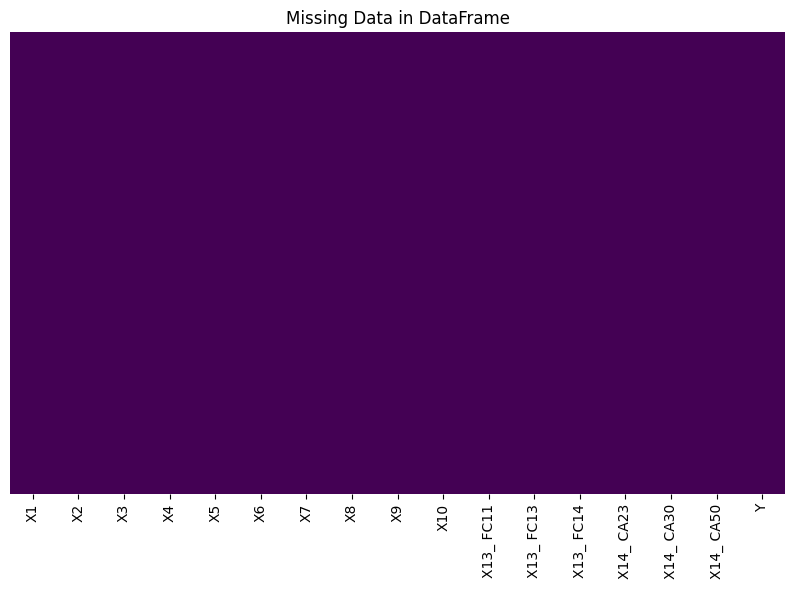

In [5]:
def display_dataframe_summary(dataframe, sort_by='Column'):

    summary = pd.DataFrame({
        'Column': dataframe.columns,
        'Non-Null Count': dataframe.notnull().sum(),
        'Dtype': dataframe.dtypes,
        'Unique Values': dataframe.nunique()
    })

    # Extracting numerical part from column names for sorting
    summary['Sort Key'] = summary['Column'].apply(lambda x: int(re.search(r'\d+', x).group()) if re.search(r'\d+', x) else 0)

    # Sorting the summary DataFrame
    if sort_by == 'Column':
        summary = summary.sort_values(by='Sort Key', ascending=True)
    else:
        summary = summary.sort_values(by=sort_by, ascending=True)

    summary = summary.drop('Sort Key', axis=1)  # Remove the auxiliary sort key column

    # Display the summary
    display(summary)

    # Plotting missing data
    plt.figure(figsize=(10, 6))
    sns.heatmap(dataframe.isnull(), yticklabels=False, cbar=False, cmap='viridis')
    plt.title('Missing Data in DataFrame')
    plt.show()

# Call the function with your DataFrame
display_dataframe_summary(train_data, sort_by='Column')


In [6]:
X_train = train_data.drop('Y', axis=1).to_numpy()
y_train = train_data['Y'].to_numpy()

X_val = val_data.drop('Y', axis=1).to_numpy()
y_val = val_data['Y'].to_numpy()

X_test = test_data.drop('Y', axis=1).to_numpy()
y_test = test_data['Y'].to_numpy()


In [7]:
classes = train_data["Y"].unique()
num_classes = len(classes)
input_features = X_train.shape[1]
categorical_cols = train_data.select_dtypes(include=['object', 'category']).columns

print(f"The classes is: {classes}")
print(f"Number of classes: {num_classes}")
print(f"Number of features: {input_features}")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}" )

print(categorical_cols)

The classes is: ['Mercedes' 'BMW' 'Honda' 'Toyota' 'GMC' 'Ford']
Number of classes: 6
Number of features: 16
X_train shape: (4250, 16), y_train shape: (4250,)
Index(['Y'], dtype='object')


# Building Model

In [8]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier


best_va = -1 # validation accuracy
best_model = None
best_n_estimators = None
best_estimator = None
best_algorithm = None

n_estimators = [50, 100, 200, 400, 1000]
estimators = [None, DecisionTreeClassifier(criterion="log_loss", max_depth=3, random_state=777), DecisionTreeClassifier(criterion="gini", max_depth=3, random_state=777), DecisionTreeClassifier(criterion="entropy", max_depth=3, random_state=777)]
algorithms = ["SAMME", "SAMME.R"]
for n_estimator in n_estimators:
    for estimator in estimators:
        for algorithm in algorithms:
            print(f"Current setting: n_estimators={n_estimator}, estimator={estimator.__class__.__name__}, algorithm={algorithm}")
            model = AdaBoostClassifier(estimator=estimator, n_estimators=n_estimator, algorithm=algorithm, random_state=777)
            model.fit(X_train, y_train)
            ta = f1_score(y_train, model.predict(X_train), average='weighted')
            va = f1_score(y_val, model.predict(X_val), average='weighted')
            
            print(f"Train F1 score: {ta:.2f}")
            print(f"Validation F1 score: {va:.2f}")
            if best_va < va:
                best_va = va
                best_model = model
                best_n_estimators = n_estimator
                best_estimator = estimator
                best_algorithm = algorithm



Current setting: n_estimators=50, estimator=DecisionTreeClassifier, algorithm=SAMME
Train F1 score: 0.87
Validation F1 score: 0.84
Current setting: n_estimators=50, estimator=DecisionTreeClassifier, algorithm=SAMME.R
Train F1 score: 0.67
Validation F1 score: 0.65
Current setting: n_estimators=50, estimator=DecisionTreeClassifier, algorithm=SAMME
Train F1 score: 0.88
Validation F1 score: 0.83
Current setting: n_estimators=50, estimator=DecisionTreeClassifier, algorithm=SAMME.R
Train F1 score: 0.52
Validation F1 score: 0.50
Current setting: n_estimators=50, estimator=DecisionTreeClassifier, algorithm=SAMME
Train F1 score: 0.87
Validation F1 score: 0.84
Current setting: n_estimators=50, estimator=DecisionTreeClassifier, algorithm=SAMME.R
Train F1 score: 0.67
Validation F1 score: 0.65
Current setting: n_estimators=100, estimator=DecisionTreeClassifier, algorithm=SAMME
Train F1 score: 0.87
Validation F1 score: 0.82
Current setting: n_estimators=100, estimator=DecisionTreeClassifier, algorit

# Best Setting

In [9]:
# Print out the best model after the loop
print(f"Best model: n_estimators={best_n_estimators}, estimator={best_estimator.__class__.__name__} with a criterion={best_estimator.criterion}, algorithm={best_algorithm}, Validation Accuracy: {best_va:.2f}")

Best model: n_estimators=50, estimator=DecisionTreeClassifier with a criterion=log_loss, algorithm=SAMME, Validation Accuracy: 0.84


# Testing

In [10]:
y_pred = best_model.predict(X_test)

# Calculate the F1 score
test_f1_score = f1_score(y_test, y_pred, average='weighted')

print(f"Test F1 Score: {test_f1_score:.2f}")

Test F1 Score: 0.85


In [11]:
report = classification_report(y_test, y_pred, target_names=classes)
print(report)


              precision    recall  f1-score   support

    Mercedes       0.87      0.88      0.87       221
         BMW       0.70      0.74      0.72        19
       Honda       0.72      0.78      0.75        46
      Toyota       0.80      0.84      0.82       211
         GMC       0.91      0.87      0.89       246
        Ford       0.84      0.80      0.82       174

    accuracy                           0.85       917
   macro avg       0.81      0.82      0.81       917
weighted avg       0.85      0.85      0.85       917



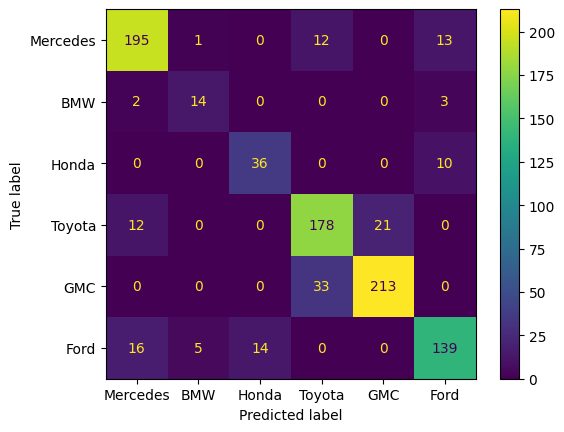

In [12]:
confusion_matrix = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = classes)

cm_display.plot()
plt.show()